In [23]:
import numpy as np
import pandas as pd
from plotnine import *

In [24]:
df_test = pd.read_csv('evalData.csv')

In [25]:
df_train = pd.read_csv('trainData.csv')
df_train.head()

,Unnamed: 0,date,fligth_number,origin,destination,distance,noshow,denied_boarding,pax_midlow,pax_high,...,pax_freqflyer,group_bookings,out_of_stock,dom_cnx,int_cnx,p2p,departure_time,capacity,revenues_usd,bookings
0,389083,2009-11-09,8995,BBA,SCL,1394,9.0,0,94,2,...,22,19,0,1,0,239,10:30:00,174.0,10631.1,240
1,177073,2009-05-23,7061,LIM,TRU,489,0.0,0,100,4,...,25,0,0,19,9,192,19:20:00,174.0,5453.7,220
2,1040357,2011-05-09,8972,SCL,PUQ,2180,4.0,0,7,1,...,2,0,0,0,10,69,09:54:00,218.0,16161.0,79
3,505258,2010-02-12,6039,CGH,CNF,524,13.0,0,54,4,...,4,0,0,26,0,64,21:00:00,174.0,10828.7,90
4,369663,2009-10-24,7713,GPS,GYE,1170,14.0,0,21,88,...,0,88,1,23,3,183,12:40:00,144.0,16721.6,209


# Limpieza de datos

In [26]:
# Eliminar columna Unnamed: 0; parece ser un identificador innecesario
df_train = df_train.drop(columns=["Unnamed: 0"])

La variable 'fligth_number' pareciera ser como una 'etiqueta' que no tiene información. Pero si vemos la cantidad de números únicos de vuelo en la base, encontramos que son 4026 en un millón de datos, por lo que en realidad no parece ser un marcador sino que se repite varias veces (app 250 veces si estuvieran equitativos), por lo que puede contener información relevante y no la eliminaremos.

In [27]:
print('Números únicos de fligth_number:', df_train['fligth_number'].nunique())
len(df_train)/df_train['fligth_number'].nunique() # hay app 237 vuelos para cada flight number, no es una 'etiqueta' unica por vuelo, quizas sirve

Números únicos de fligth_number: 4026


248.35817188276204

Revisar datos faltantes:

In [28]:
df_train.isna().sum()
# La variable departure_time "hora programada de despegue" presenta datos nulos

date                  0
fligth_number         0
origin                0
destination           0
distance              0
noshow                0
denied_boarding       0
pax_midlow            0
pax_high              0
pax_midhigh           0
pax_low               0
pax_freqflyer         0
group_bookings        0
out_of_stock          0
dom_cnx               0
int_cnx               0
p2p                   0
departure_time     1418
capacity              0
revenues_usd          0
bookings              0
dtype: int64

Se tienen sólo 1418 valores faltantes en la variable 'departure_time'.
Consideramos que esta variable puede ser relevante para el trabajo, porque indica la hora en que debe salir el avión, y es probable que esto afecte en la cantidad de 'no show'. 
Como se tienen 999890 filas, y 1418 filas con datos faltantes, son sólo el 0.14% de los datos.

Podriamos eliminar los nulos, pero como el df_test tambien tiene faltantes y necesitamos predecir si o si todos los test, podemos
- eliminar la variable completa
- imputar por media o mediana


Por mientras, imputamos por la mediana.
Pero para esto, primero tenemos que trabajar los formatos, no se puede calcular la mediana con el formato hh:mm:ss

**Revisar los Formatos:**

Para las variables de fechas y tiempo, debemos ajustar los formatos, ya que no nos sirven tal como están para el modelo.
- **date:** esta en formato yyyy:mm:dd. Para predecir, no nos interesa realmente el año, no entrega info. para predecir (no vamos a volver a esos años). El día del mes tampoco es relevante, considerando el problema. El mes podría contener información interesante, por ejemplo por las fechas que tienen más viajes como Navidad, por lo que dejamos sólo esa información.

- **departure_time:** La variable 'departure_time' tiene formato hh:mm:ss. No nos sirve así, y la información realmente relevante es la hora en sí (hh), por lo que conservamos sólo esa parte. (Quizás viajes en la madrugada se pierden más pq no llegan o algo así?)

In [29]:
import pandas as pd

# Transformación para date:
df_train['date'] = pd.to_datetime(df_train['date'])
df_train['month'] = df_train['date'].dt.month
df_train = df_train.drop(columns='date')

# Transformación para departure_time:
df_train['departure_time'] = pd.to_datetime(df_train['departure_time'], errors='coerce')  # Transformación y manejo de NaT
# Extrae solo la hora de inicio (hh) y reemplaza NaT con un -1 por mientras
df_train['departure_time'] = df_train['departure_time'].apply(lambda x: x.hour if not pd.isna(x) else -1)

# Calcula la mediana de las horas de inicio (ignorando los valores -1)
median_departure_time = df_train['departure_time'][df_train['departure_time'] != -1].median()

# Imputa los valores -1 en 'departure_time' con la mediana
df_train['departure_time'].replace(-1, median_departure_time, inplace=True)

C:\Users\acata\AppData\Local\Temp\ipykernel_23904\364324107.py:9: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.


**Con respecto a las variables categóricas nominales:**
- origin: Aeropuerto de origen
- destination: Aeropuerto de destino

Consideramos la opción de hacer one-hot encoding, lo que crearía demasiadas variables binarias, las que no son ideales para métodos de distancia como KNN-regressor (ya que no existe un concepto real de distancia). 
Entonces, considerando que la información sobre el aeropuerto no parece vital para predecir el número de no-shows, no consideraremos estas en el df final.

Luego, para la variable 
- 'denied_boarding': indica el número de pasajeros que no pudieron abordar por vuelo sobre reservado. 

Como el objetivo principal de este proyecto es estimar el número de no show en su vuelo, **antes** de que salga un vuelo, no se debería usar esta variable como predictora, por lo que tampoco se considera en el df.

In [30]:
# Eliminar las columnas origin, destination y denied_boarding del df
columnas_eliminar = ['origin', 'destination', 'denied_boarding']
df_train = df_train.drop(columns=columnas_eliminar)

Para las **variables numéricas**, hacemos boxplots para tener una idea general de los datos 

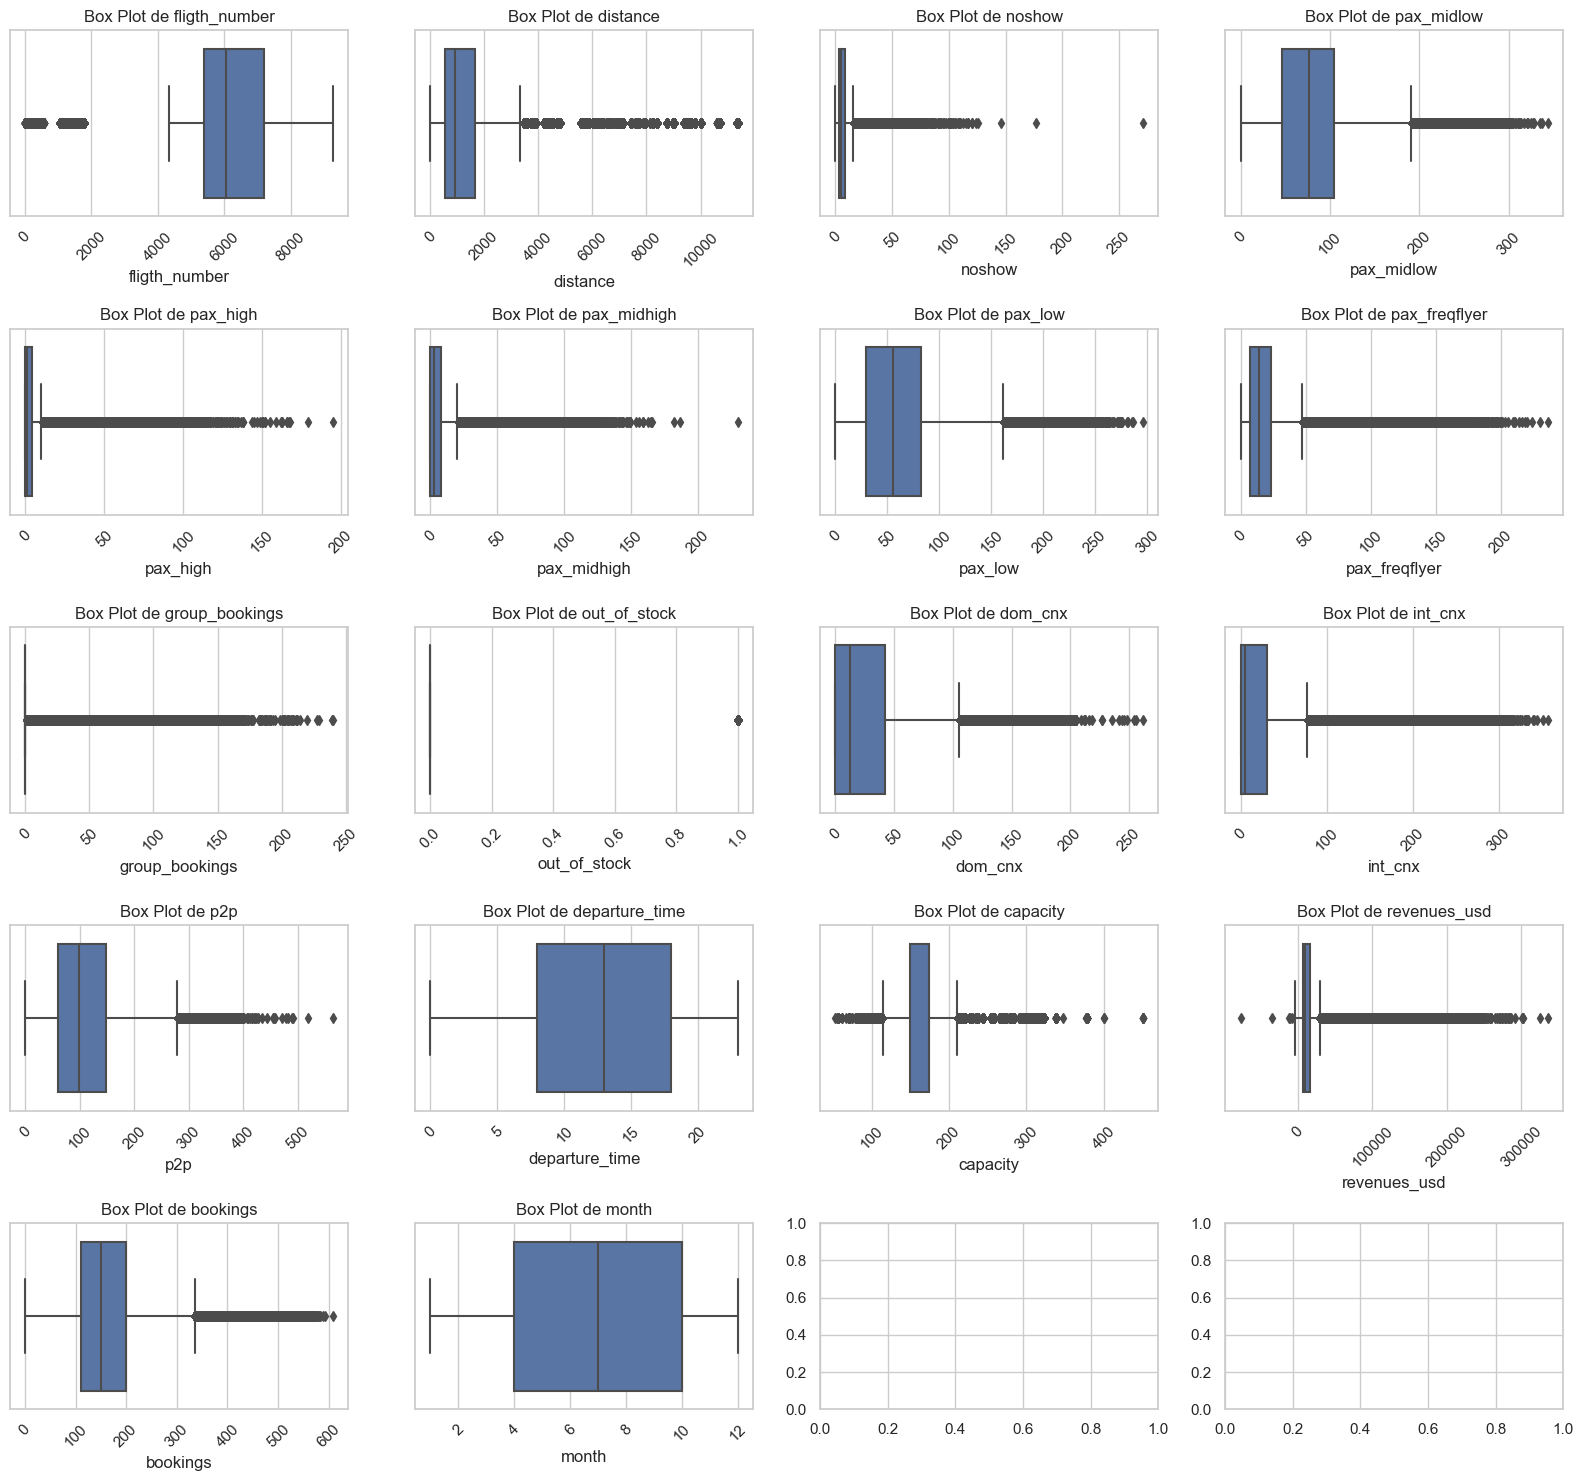

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt

numeric_columns = df_train.select_dtypes(include=['number']).columns
sns.set(style="whitegrid")
plots_per_row = 4
num_rows = (len(numeric_columns) + plots_per_row - 1) // plots_per_row

fig, axes = plt.subplots(num_rows, plots_per_row, figsize=(16, 3 * num_rows))

for i, column in enumerate(numeric_columns):
    row = i // plots_per_row
    col = i % plots_per_row
    sns.boxplot(data=df_train, x=column, ax=axes[row, col])
    axes[row, col].set_xlabel(column)
    axes[row, col].set_title(f'Box Plot de {column}')
    axes[row, col].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

Podemos ver que en la variable 'revenues_usd' hay (7) valores negativos. Estos podrían ser outliers, ya que esta variable indica ingresos en dólares, pero también podría indicar pérdida de dinero, por lo que los dejaremos tal como están.

En los boxplots se puede notar en varias variables (por ejemplo, la variable a predecir 'noshow'), hay varias observaciones muy altas, que podrían tratarse de datos atípicos, por ejemplo el valor de noshow=300 podría deberse a un evento excepcional.

Pero como se va a entrenar un modelo que luego debe predecir para cualquier set de datos, es mejor que 'aprenda' con todos los datos posibles, incluídos estos más extraños, ya que así puede saber qué hacer con estos en un futuro.

In [32]:
df_train

,fligth_number,distance,noshow,pax_midlow,pax_high,pax_midhigh,pax_low,pax_freqflyer,group_bookings,out_of_stock,dom_cnx,int_cnx,p2p,departure_time,capacity,revenues_usd,bookings,month
0,8995,1394,9.0,94,2,28,94,22,19,0,1,0,239,10,174.0,10631.1,240,11
1,7061,489,0.0,100,4,4,87,25,0,0,19,9,192,19,174.0,5453.7,220,5
2,8972,2180,4.0,7,1,5,64,2,0,0,0,10,69,9,218.0,16161.0,79,5
3,6039,524,13.0,54,4,7,21,4,0,0,26,0,64,21,174.0,10828.7,90,2
4,7713,1170,14.0,21,88,18,82,0,88,1,23,3,183,12,144.0,16721.6,209,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999885,6024,552,5.0,25,12,20,4,12,0,0,64,9,0,15,144.0,14102.1,73,10
999886,6669,3934,4.0,129,3,19,121,2,20,0,0,118,156,8,168.0,32907.8,274,5
999887,9094,1430,5.0,2,1,0,108,20,36,0,7,0,124,14,218.0,13519.3,131,4
999888,7704,1091,2.0,67,2,7,42,16,0,0,34,2,98,8,144.0,8729.6,134,4


Como tenemos que seleccionar un conjunto de variables para entrenar modelos distintos (knn y regression tree), probamos seleccionando las que funcionan mejor para ambos por separado, y después hacer un conjunto final que contenga las características seleccionadas por ambos. 

# Selección de variables para kNN utilizando Forward selection 

In [33]:
# Definimos la función para calcular el sMAPE, que se usará mucho

def smape(y_true, y_pred):
    num = np.abs(y_true - y_pred)
    den = np.abs(y_true) + np.abs(y_pred)
    return 100 * np.nan_to_num((num / den).mean())

from sklearn.metrics import make_scorer
smape_scorer = make_scorer(smape, greater_is_better=False)

In [64]:
# Hacemos una muestra aleatoria del df para ahorrar tiempo
import pandas as pd
sample_size = round(956944/2) # 50% de los datos
df_train_sample = df_train.sample(n=sample_size, random_state=42)  

Para hacer forward selection con kNN, debemos definir el número de vecinos (n_neighbors) que utilizará el modelo.
Como para saber el número óptimo debemos tener definidas las variables a utilizar, corrimos códigos con distintos valores para n_neighbors, para ver si seleccionan las mismas variables, o similares.

In [35]:
# Para n_neighbors = 10, 4 variables

from sklearn.neighbors import KNeighborsRegressor
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import make_scorer
import numpy as np
import pandas as pd

n_neighbors = 10
knn = KNeighborsRegressor(n_neighbors=n_neighbors)

# Inicializa el SequentialFeatureSelector
sfs = SequentialFeatureSelector(
    knn, # El modelo
    direction = 'forward',  # Ppara forward selection
    scoring = smape_scorer,  # Función de puntuación
    cv = 5, # Con cross-validation (5-fold)
    n_features_to_select = 4, # Depende de 'tol'
    tol = 0.1) # Para cuando al agregar una variable, el smape no disminuye ni 0.1

# Escalar datos (importante para kNN - distancias)
scaler = StandardScaler()
X = scaler.fit_transform(df_train_sample.drop('noshow', axis=1))
# Ajustar el SequentialFeatureSelector 
sfs = sfs.fit(X, df_train_sample['noshow'])
# Obtener las características seleccionadas
selected_features = df_train_sample.drop('noshow', axis=1).columns[sfs.get_support()]

# Para tener una idea de cómo funciona el modelo con estas características:
# Ajusta el modelo KNN Regressor con las características seleccionadas
knn_selected = KNeighborsRegressor(n_neighbors=n_neighbors)
knn_selected.fit(X[:, sfs.get_support()], df_train_sample['noshow'])

# Calcula la puntuación sMAPE con conjunto de características seleccionado
y_pred_selected = knn_selected.predict(X[:, sfs.get_support()])
smape_selected = smape(df_train_sample['noshow'], y_pred_selected)

print("Caracteristicas seleccionadas: ", selected_features)
print("Puntuación SMAPE del conjunto seleccionado:", smape_selected)

Caracteristicas seleccionadas:  Index(['fligth_number', 'distance', 'departure_time', 'capacity'], dtype='object')
Puntuación SMAPE del conjunto seleccionado: 30.789279602420283


In [36]:
# Para n_neighbors = 10, 5 variables

from sklearn.neighbors import KNeighborsRegressor
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import make_scorer
import numpy as np
import pandas as pd

n_neighbors = 10
knn = KNeighborsRegressor(n_neighbors=n_neighbors)

# Inicializa el SequentialFeatureSelector
sfs = SequentialFeatureSelector(
    knn, # El modelo
    direction = 'forward',  # Ppara forward selection
    scoring = smape_scorer,  # Función de puntuación
    cv = 5, # Con cross-validation (5-fold)
    n_features_to_select = 5, # Depende de 'tol'
    tol = 0.1) # Para cuando al agregar una variable, el smape no disminuye ni 0.1

# Escalar datos (importante para kNN - distancias)
scaler = StandardScaler()
X = scaler.fit_transform(df_train_sample.drop('noshow', axis=1))
# Ajustar el SequentialFeatureSelector 
sfs = sfs.fit(X, df_train_sample['noshow'])
# Obtener las características seleccionadas
selected_features = df_train_sample.drop('noshow', axis=1).columns[sfs.get_support()]

# Para tener una idea de cómo funciona el modelo con estas características:
# Ajusta el modelo KNN Regressor con las características seleccionadas
knn_selected = KNeighborsRegressor(n_neighbors=n_neighbors)
knn_selected.fit(X[:, sfs.get_support()], df_train_sample['noshow'])

# Calcula la puntuación sMAPE con conjunto de características seleccionado
y_pred_selected = knn_selected.predict(X[:, sfs.get_support()])
smape_selected = smape(df_train_sample['noshow'], y_pred_selected)

print("Caracteristicas seleccionadas: ", selected_features)
print("Puntuación SMAPE del conjunto seleccionado:", smape_selected)

Caracteristicas seleccionadas:  Index(['fligth_number', 'distance', 'out_of_stock', 'departure_time',
       'capacity'],
      dtype='object')
Puntuación SMAPE del conjunto seleccionado: 30.64458120072394


In [65]:
# Para n_neighbors = 20, 7 variables

from sklearn.neighbors import KNeighborsRegressor
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import make_scorer
import numpy as np
import pandas as pd

n_neighbors = 20
knn = KNeighborsRegressor(n_neighbors=n_neighbors)

# Inicializa el SequentialFeatureSelector
sfs = SequentialFeatureSelector(
    knn, # El modelo
    direction = 'forward',  # Ppara forward selection
    scoring = smape_scorer,  # Función de puntuación
    cv = 5, # Con cross-validation (5-fold)
    n_features_to_select = 7, # Depende de 'tol'
    tol = 0.1) # Para cuando al agregar una variable, el smape no disminuye ni 0.1

# Escalar datos (importante para kNN - distancias)
scaler = StandardScaler()
X = scaler.fit_transform(df_train_sample.drop('noshow', axis=1))
# Ajustar el SequentialFeatureSelector 
sfs = sfs.fit(X, df_train_sample['noshow'])
# Obtener las características seleccionadas
selected_features = df_train_sample.drop('noshow', axis=1).columns[sfs.get_support()]

# Para tener una idea de cómo funciona el modelo con estas características:
# Ajusta el modelo KNN Regressor con las características seleccionadas
knn_selected = KNeighborsRegressor(n_neighbors=n_neighbors)
knn_selected.fit(X[:, sfs.get_support()], df_train_sample['noshow'])

# Calcula la puntuación sMAPE con conjunto de características seleccionado
y_pred_selected = knn_selected.predict(X[:, sfs.get_support()])
smape_selected = smape(df_train_sample['noshow'], y_pred_selected)

print("Caracteristicas seleccionadas: ", selected_features)
print("Puntuación SMAPE del conjunto seleccionado:", smape_selected)

In [37]:
# Para n_neighbors = 5

from sklearn.neighbors import KNeighborsRegressor
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import make_scorer
import numpy as np

import pandas as pd

n_neighbors = 5

# Ajusta el SequentialFeatureSelector, ahora con kNN con n_neighbors = 5
sfs = sfs.fit(X, df_train_sample['noshow'])

# Obtener las características seleccionadas
selected_features = df_train_sample.drop('noshow', axis=1).columns[sfs.get_support()]

# Ajusta el modelo KNN Regressor con las características seleccionadas
knn_selected = KNeighborsRegressor(n_neighbors=n_neighbors)
knn_selected.fit(X[:, sfs.get_support()], df_train_sample['noshow'])

# Calcula la puntuación sMAPE en el conjunto de características seleccionado
y_pred_selected = knn_selected.predict(X[:, sfs.get_support()])
smape_selected = smape(df_train_sample['noshow'], y_pred_selected)

print("Caracteristicas seleccionadas: ", selected_features)
print("Puntuación SMAPE del conjunto seleccionado:", smape_selected)

Caracteristicas seleccionadas:  Index(['fligth_number', 'distance', 'out_of_stock', 'departure_time',
       'capacity'],
      dtype='object')
Puntuación SMAPE del conjunto seleccionado: 31.21226604774097


In [38]:
# Para n_neighbors = 20

from sklearn.neighbors import KNeighborsRegressor
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import make_scorer
import numpy as np
import pandas as pd

n_neighbors = 20
knn = KNeighborsRegressor(n_neighbors=n_neighbors)

# Inicializa el SequentialFeatureSelector
sfs = SequentialFeatureSelector(
    knn, # El modelo
    direction = 'forward',  # Ppara forward selection
    scoring = smape_scorer,  # Función de puntuación
    cv = 5, # Con cross-validation (5-fold)
    n_features_to_select = 'auto', # Depende de 'tol'
    tol = 0.1) # Para cuando al agregar una variable, el smape no disminuye ni 0.1

# Escalar datos (importante para kNN - distancias)
scaler = StandardScaler()
X = scaler.fit_transform(df_train_sample.drop('noshow', axis=1))
# Ajustar el SequentialFeatureSelector 
sfs = sfs.fit(X, df_train_sample['noshow'])
# Obtener las características seleccionadas
selected_features = df_train_sample.drop('noshow', axis=1).columns[sfs.get_support()]

# Para tener una idea de cómo funciona el modelo con estas características:
# Ajusta el modelo KNN Regressor con las características seleccionadas
knn_selected = KNeighborsRegressor(n_neighbors=n_neighbors)
knn_selected.fit(X[:, sfs.get_support()], df_train_sample['noshow'])

# Calcula la puntuación sMAPE con conjunto de características seleccionado
y_pred_selected = knn_selected.predict(X[:, sfs.get_support()])
smape_selected = smape(df_train_sample['noshow'], y_pred_selected)

print("Caracteristicas seleccionadas: ", selected_features)
print("Puntuación SMAPE del conjunto seleccionado:", smape_selected)

Caracteristicas seleccionadas:  Index(['fligth_number', 'departure_time'], dtype='object')
Puntuación SMAPE del conjunto seleccionado: 30.880039473278188


Todos seleccionaron las mismas variables: 'fligth_number', 'distance', 'departure_time'.
Pero cuando obligamos a que sean 4 y 5, se agregaron: 'capacity' y 'out_of_stock'
['fligth_number', 'distance', 'out_of_stock', 'departure_time',
       'capacity']

# Selección de variables para regression tree

Para seleccionar las características en un árbol de regresión, podemos aprovechar que estos indican la importancia de las variables en el modelo en feature_importances_. 
Como para esto hay que entrenar un árbol, necesitamos entregarle hiperparámetros. El de mayor importancia sería la profundidad máxima, ya que sin esta el árbol aumentará hasta aprender todos los datos (overfit).

Entonces, para tener una idea de qué profundidad máxima (max_depth) usar para el árbol, probamos con el método gráfico de puntaje vs max_depth, primero utilizando todas las variables del df. Como en la tarea buscamos minimizar el sMAPE, utilizamos este puntaje.


Ver el max_depth óptimo usando todas las variables

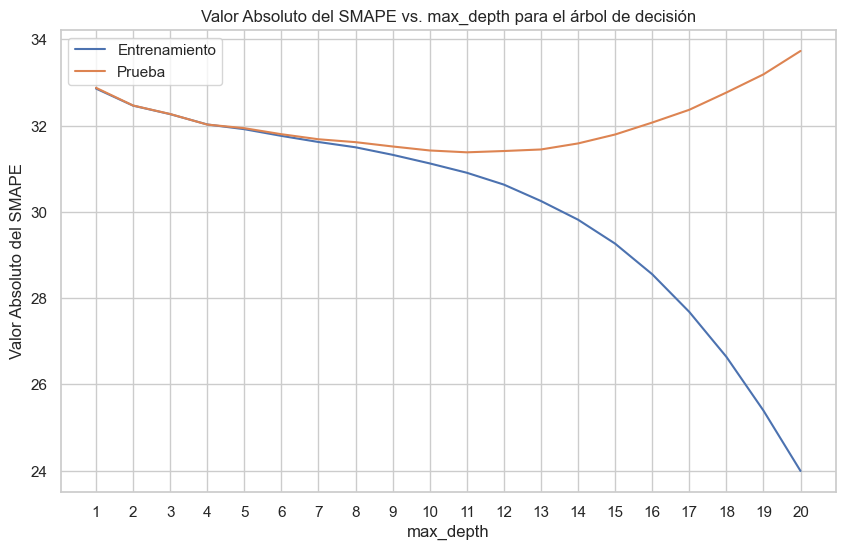

In [39]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import make_scorer
from sklearn.model_selection import train_test_split

X = df_train_sample.drop('noshow', axis=1)
y = df_train_sample['noshow']

# Dividir datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Lista de valores de max_depth para probar
max_depth_values = range(1, 21)

train_smape = []
test_smape = []

# Realiza un bucle para todos los valores de max_depth
for max_depth in max_depth_values:
    # Crear un modelo de árbol de decisión con el valor actual de max_depth
    model = DecisionTreeRegressor(max_depth=max_depth)

    # Entrenar el modelo en el conjunto de entrenamiento
    model.fit(X_train, y_train)

    # Realiza las predicciones en el conjunto de entrenamiento
    y_pred_train = model.predict(X_train)

    # Calcula el sMAPE en el conjunto de entrenamiento
    train_smape_score = np.abs(smape(y_train, y_pred_train))

    # Realiza las predicciones en el conjunto de prueba
    y_pred_test = model.predict(X_test)

    # Calcula el sMAPE en el conjunto de prueba
    test_smape_score = np.abs(smape(y_test, y_pred_test))

    # Agrega los valores de los sMAPE a las listas
    train_smape.append(train_smape_score)
    test_smape.append(test_smape_score)

# Graficar max_depth vs. valor absoluto del SMAPE 
plt.figure(figsize=(10, 6))
plt.plot(max_depth_values, train_smape, label='Entrenamiento')
plt.plot(max_depth_values, test_smape, label='Prueba')
plt.xlabel('max_depth')
plt.ylabel('Valor Absoluto del SMAPE')
plt.title('Valor Absoluto del SMAPE vs. max_depth para el árbol de decisión')
plt.xticks(max_depth_values)
plt.legend()
plt.grid(True)
plt.show()

Según este gráfico, podríamos elegir max_depth hasta aprox. 7. 
Probamos entrenando el modelo usando max_depth = 5.

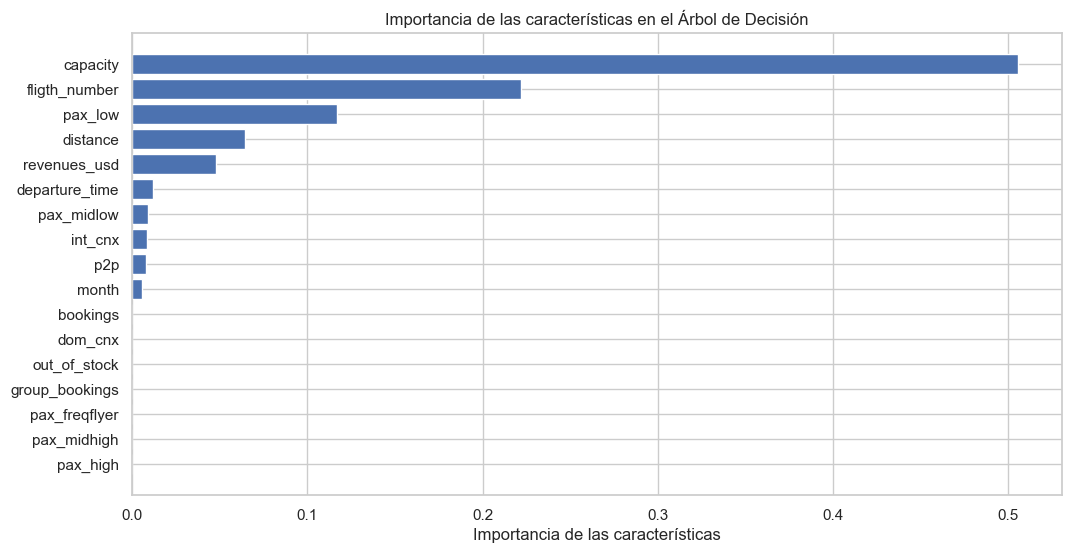

SMAPE promedio: 31.907306289647977


In [40]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeRegressor
dtree = DecisionTreeRegressor(max_depth=5, random_state=42)
dtree.fit(X, y)

# Obtener la importancia de las variables
feature_importances = dtree.feature_importances_
feature_names = X.columns

# Ordenarlos de mayor a menor para más orden
feature_importance_names = list(zip(feature_names, feature_importances))
feature_importance_names.sort(key=lambda x: x[1], reverse=False)
sorted_feature_names, sorted_feature_importances = zip(*feature_importance_names)

# Graficar
plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_feature_importances)), sorted_feature_importances, align='center')
plt.yticks(np.arange(len(sorted_feature_importances)), sorted_feature_names)
plt.xlabel('Importancia de las características')
plt.title('Importancia de las características en el Árbol de Decisión')
plt.show()

scores = cross_val_score(dtree, X, y, cv=5, scoring=smape_scorer)
print("SMAPE promedio:", -scores.mean()) 

Probar con un max_depth mayor (ya vimos probando cosas que el max_depth óptimo son valores entre 10-17)

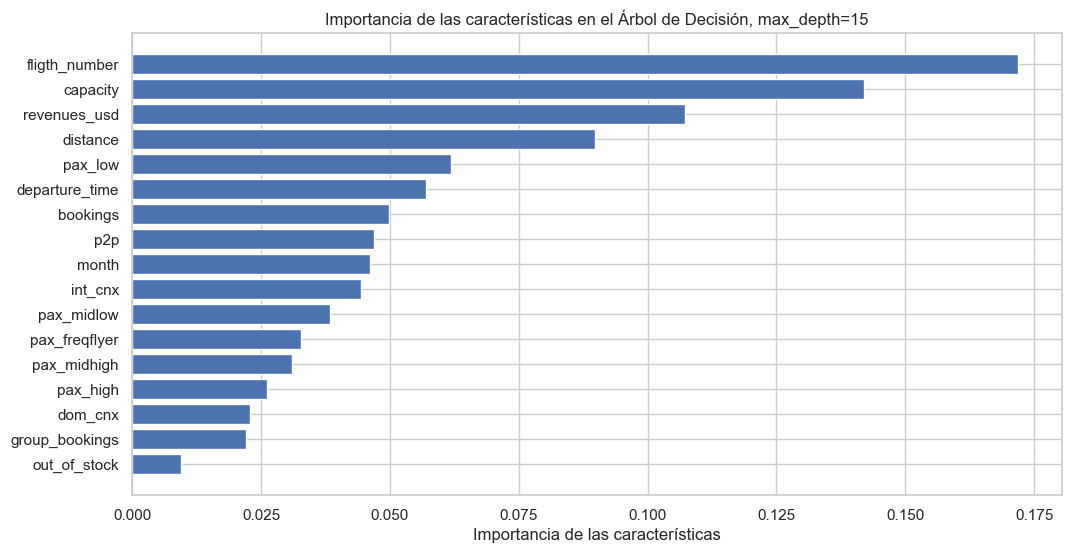

SMAPE promedio: 31.680624817568873


In [41]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeRegressor
dtree = DecisionTreeRegressor(max_depth=15, random_state=42)
dtree.fit(X, y)

# Obtener la importancia de las variables
feature_importances = dtree.feature_importances_
feature_names = X.columns

# Ordenarlos de mayor a menor para más orden
feature_importance_names = list(zip(feature_names, feature_importances))
feature_importance_names.sort(key=lambda x: x[1], reverse=False)
sorted_feature_names, sorted_feature_importances = zip(*feature_importance_names)

# Graficar
plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_feature_importances)), sorted_feature_importances, align='center')
plt.yticks(np.arange(len(sorted_feature_importances)), sorted_feature_names)
plt.xlabel('Importancia de las características')
plt.title('Importancia de las características en el Árbol de Decisión, max_depth=15')
plt.show()

scores = cross_val_score(dtree, X, y, cv=5, scoring=smape_scorer)
print("SMAPE promedio:", -scores.mean()) 

Ahora, probamos sin un max_depth definido la importancia de las características para comparar

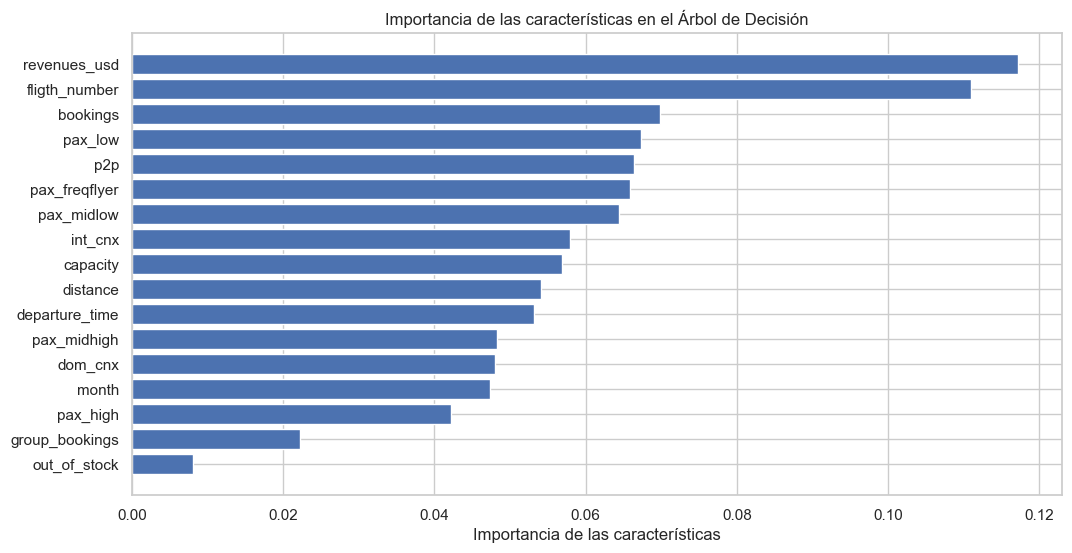

SMAPE promedio: 41.340702517356924


In [42]:
import numpy as np
import matplotlib.pyplot as plt

# Ajusta un árbol de decisión SIN MAX DEPTH
from sklearn.tree import DecisionTreeRegressor
dtree = DecisionTreeRegressor(random_state=42)
dtree.fit(X, y)

# Obtiene la importancia de las características
feature_importances = dtree.feature_importances_

# Obtiene el nombre de las características
feature_names = X.columns

# Combina los nombres de las características con sus importancias y luego ordena
feature_importance_names = list(zip(feature_names, feature_importances))
feature_importance_names.sort(key=lambda x: x[1], reverse=False)
sorted_feature_names, sorted_feature_importances = zip(*feature_importance_names)

# Crea un gráfico de barras para mostrar la importancia de las características
plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_feature_importances)), sorted_feature_importances, align='center')
plt.yticks(np.arange(len(sorted_feature_importances)), sorted_feature_names)
plt.xlabel('Importancia de las características')
plt.title('Importancia de las características en el Árbol de Decisión')
plt.show()

scores = cross_val_score(dtree, X, y, cv=5, scoring=smape_scorer)
print("SMAPE promedio:", -scores.mean())

# Resumen:
**Variables para kNN:**
- n=5: 'fligth_number', 'distance', 'departure_time' (smape app 30%)
- n=10: 'fligth_number', 'distance', 'departure_time' (smape app 30%)

**Variables para Regression tree:**
- max_depth=5: 'capacity', 'fligth_number', 'pax_low', 'distance', 'revenues_usd', 'departure_time', 'pax_midlow', 'int_cnx', 'p2p', 'month' (smape app 31.9%)
- max_depth=15: 'fligth_number', 'capacity', 'revenues_usd', 'pax_low', 'distance', 'p2p', 'pax_midlow', 'departure_time', 'int_cnx', 'month'

**Seleccionadas (para ir probando combinaciones):**
- **kNN:** 'fligth_number', 'distance', 'departure_time'
- **Árbol:** 'capacity', 'fligth_number', 'pax_low', 'revenues_usd', 'distance' -menos importantes- 'p2p', 'pax_midlow', 'departure_time', 'int_cnx', 'month'

*Se repiten en kNN y árbol: 'fligth_number', 'distance', 'departure_time'*

# Búsqueda de hiperparámetros y aplicación de kNN

In [43]:
selected_features_knn = ['fligth_number', 'distance', 'departure_time', 'capacity']#, 'capacity', 'pax_low', 'revenues_usd', 'pax_midlow', 'int_cnx', 'p2p', 'month']

sample_size = round(956944/2) #PARA IR PROBANDO, CON TIEMPO HACERLO CON EL DF COMPLETO (O SAMPLE MÁS GRANDE)
df_train_sample = df_train.sample(n=sample_size, random_state=42) 

X = df_train_sample[selected_features_knn]
y = df_train_sample['noshow']

# # Datos completos
# X = df_train[selected_features]
# y = df_train['noshow]

Usando RandomizedSearchCV:

In [44]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neighbors import KNeighborsRegressor
import numpy as np

# Definir la secuencia de valores para n_neighbors
n_neighbors_values = list(range(1, 100))

knn_random = KNeighborsRegressor()

# Espacio de búsqueda de hiperparámetros
param_dist_knn = {
    'n_neighbors': n_neighbors_values
}

# Búsqueda con validación cruzada utilizando RandomizedSearchCV
n_iter_knn = 100
random_search = RandomizedSearchCV(knn_random, param_distributions=param_dist_knn, cv=5, scoring=smape_scorer, n_iter=n_iter_knn, random_state=42)
random_search.fit(X, y)  # X e y son los datos de entrenamiento

best_k_random = random_search.best_params_['n_neighbors']
print(best_k_random)

C:\Users\acata\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_search.py:307: UserWarning: The total space of parameters 99 is smaller than n_iter=100. Running 99 iterations. For exhaustive searches, use GridSearchCV.


48


Entrenar kNN usando el mejor parámetro encontrado con la búsqueda random

In [58]:
X = df_train[selected_features_knn]
y = df_train['noshow']

from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, mean_absolute_error, mean_squared_error, r2_score, mean_squared_error
import numpy as np 

# Crear modelo KNeighborsRegressor con el mejor valor de n_neighbors best_k_random
knn_reg = KNeighborsRegressor(n_neighbors=best_k_random)

# Validación cruzada y calcula las métricas
smape_scores_knn = cross_val_score(knn_reg, X, y, cv=5, scoring=smape_scorer)
mae_scores_knn = -cross_val_score(knn_reg, X, y, cv=5, scoring='neg_mean_absolute_error')
mse_scores_knn = -cross_val_score(knn_reg, X, y, cv=5, scoring='neg_mean_squared_error')
r2_scores_knn = cross_val_score(knn_reg, X, y, cv=5, scoring='r2')

mean_smape_knn = smape_scores_knn.mean()
std_smape_knn  = smape_scores_knn.std()
mean_mse_knn = mse_scores_knn.mean()
std_mse_knn = mse_scores_knn.std()
mean_mae_knn = mae_scores_knn.mean()
std_mae_knn = mae_scores_knn.std()
mean_r2_knn = r2_scores_knn.mean()
std_r2_knn = r2_scores_knn.std()

print("SMAPE:", -round(mean_smape_knn,2),'+-',round(std_smape_knn,2))
print("MAE:", round(mean_mae_knn,2),'+-',round(std_mae_knn,2))
print("MSE:", round(mean_mse_knn,2),'+-',round(std_mse_knn,2))
print("R^2", round(mean_r2_knn,2),'+-',round(std_r2_knn,2))

SMAPE: 30.69 +- 0.07
MAE: 3.21 +- 0.01
MSE: 21.25 +- 0.25
R^2 0.19 +- 0.0


Ver de manera gráfica y vs y_pred

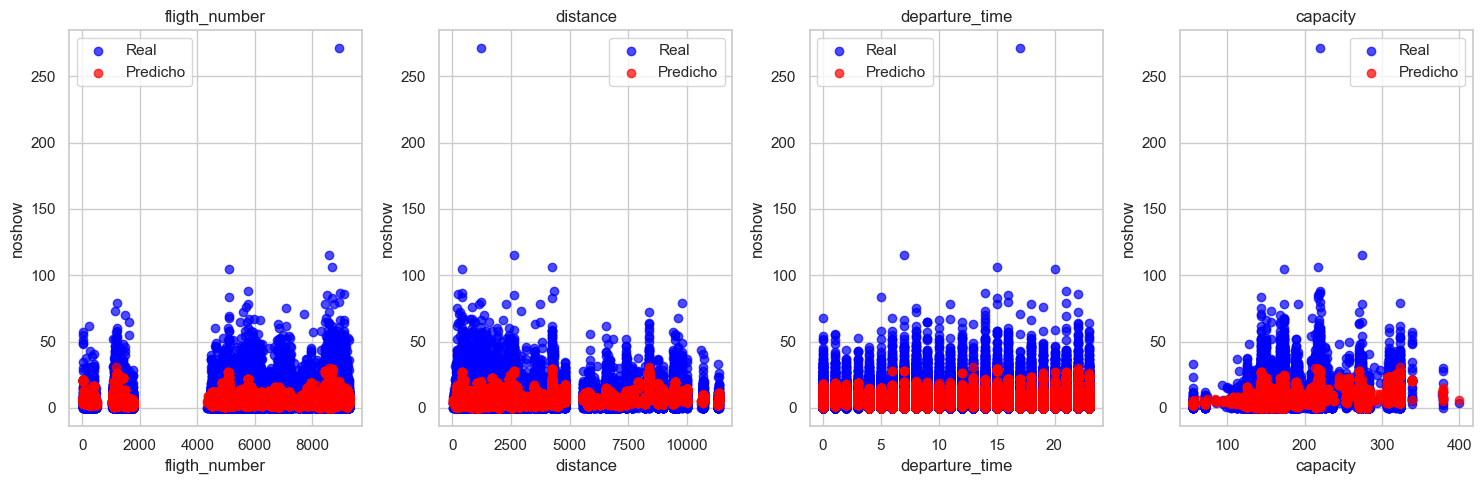

In [60]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

X = df_train[selected_features_knn]
y = df_train['noshow']

# Hacer conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

knn_reg = KNeighborsRegressor(n_neighbors=best_k_random)

knn_reg.fit(X_train, y_train)
y_pred = knn_reg.predict(X_test)

x_variables = X.columns
graphs_per_row = 4

num_rows = len(x_variables) // graphs_per_row
if len(x_variables) % graphs_per_row > 0:
    num_rows += 1

fig, axes = plt.subplots(num_rows, graphs_per_row, figsize=(15, 5 * num_rows))

if num_rows == 1:
    axes = [axes]

for i, variable in enumerate(x_variables):
    row, col = divmod(i, graphs_per_row)
    ax = axes[row][col]

    ax.scatter(X_test[variable], y_test, color='blue', label='Real', alpha=0.7)
    ax.scatter(X_test[variable], y_pred, color='red', label='Predicho', alpha=0.7)
    ax.set_xlabel(variable)
    ax.set_ylabel("noshow")
    ax.set_title(f"{variable}")
    ax.legend()

plt.tight_layout()
plt.show()

# Búsqueda de hiperparámetros y aplicación de regression tree

In [47]:
selected_features_arbol = ['capacity', 'fligth_number', 'pax_low', 'revenues_usd', 'distance', 'month', 'departure_time'] #,'int_cnx' 
sample_size = round(956944/2) #PARA IR PROBANDO, CON TIEMPO HACERLO CON EL DF COMPLETO (O SAMPLE MÁS GRANDE)
df_train_sample = df_train.sample(n=sample_size, random_state=42) 

X = df_train_sample[selected_features_arbol]
y = df_train_sample['noshow']

# # Datos completos
# X = df_train[selected_features]
# y = df_train['noshow]

# importantes: 'capacity', 'fligth_number', 'pax_low', 'revenues_usd', 'distance' 
# menos importantes: 'p2p', 'pax_midlow', 'departure_time', 'int_cnx', 'month'

Usando RandomizedSearchCV:

In [48]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer
import numpy as np

tree_reg_random = DecisionTreeRegressor()

# Espacio de búsqueda de hiperparámetros
param_dist_tree_random = {
    'max_depth': list(range(1, 51)),  # Valores para max_depth (1-50)
    'min_samples_split': list(range(2, 21)),  # Valores para min_samples_split (2-20)
    'min_samples_leaf': list(range(1, 21)),  # Valores para min_samples_leaf (1-20)
}

# Búsqueda de hiperparámetros con RandomizedSearchCV
n_iter_tree = 100
random_search_tree = RandomizedSearchCV(estimator=tree_reg_random, param_distributions=param_dist_tree_random, cv=5, scoring=smape_scorer, n_iter=n_iter_tree, random_state=42)
random_search_tree.fit(X, y)

# Mejores hiperparámetros y modelo
best_max_depth_random = random_search_tree.best_params_['max_depth']
best_min_samples_split_random = random_search_tree.best_params_['min_samples_split']
best_min_samples_leaf_random = random_search_tree.best_params_['min_samples_leaf']
best_tree_reg_random = random_search_tree.best_estimator_

print("Mejor max_depth:", best_max_depth_random)
print("Mejor min_samples_split:", best_min_samples_split_random)
print("Mejor min_samples_leaf:", best_min_samples_leaf_random)  
print("Mejor modelo:", best_tree_reg_random)

Mejor max_depth: 14
Mejor min_samples_split: 12
Mejor min_samples_leaf: 20
Mejor modelo: DecisionTreeRegressor(max_depth=14, min_samples_leaf=20, min_samples_split=12)


Entrenamiento del decision tree regressor con los parámetros encontrados:

Con los parámetros obtenidos en random:

In [59]:
X = df_train[selected_features_arbol]
y = df_train['noshow']

from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
import numpy as np

best_tree_reg = DecisionTreeRegressor(
    max_depth=best_max_depth_random,
    min_samples_split=best_min_samples_split_random,
    min_samples_leaf=best_min_samples_leaf_random, 
    random_state=42
)

# Calcular SMAPE con cross validation
scores_best_tree_reg = cross_val_score(best_tree_reg, X, y, cv=5, scoring=smape_scorer)

# print("Puntajes SMAPE en cada iteración de cross-validation:")
# print(-scores_best_tree_reg)

# Media y desviación estándar de los puntajes
mean_score = scores_best_tree_reg.mean()
std_score = scores_best_tree_reg.std()

print('SMAPE:', -round(mean_score,2),'+-',round(std_score,2))

from sklearn.metrics import mean_squared_error, mean_absolute_error

# Cross-validation y para obtener los puntajes MSE y MAE
mse_scores = -cross_val_score(best_tree_reg, X, y, cv=5, scoring='neg_mean_squared_error')
mae_scores = -cross_val_score(best_tree_reg, X, y, cv=5, scoring='neg_mean_absolute_error')
r2_scores = cross_val_score(best_tree_reg, X, y, cv=5, scoring='r2')

mean_mse = mse_scores.mean()
std_mse = mse_scores.std()
mean_mae = mae_scores.mean()
std_mae = mae_scores.std()
mean_r2 = r2_scores.mean()
std_r2 = r2_scores.std()

print("MSE:", round(mean_mse,2),'+-',round(std_mse,2))
print("MAE:", round(mean_mae,2),'+-',round(std_mae,2))
print("R^2:", round(mean_r2,2),'+-',round(std_r2,2))

SMAPE: 30.95 +- 0.06
MSE: 21.51 +- 0.19
MAE: 3.24 +- 0.01
R^2: 0.18 +- 0.0


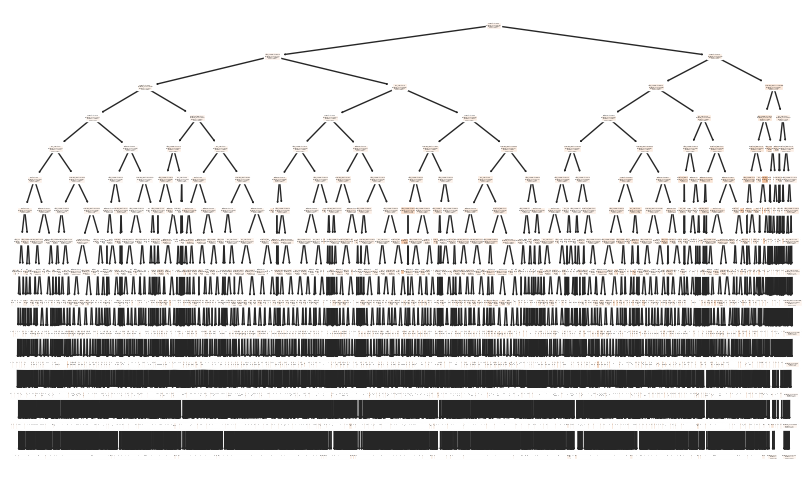

In [61]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

X = df_train[selected_features_arbol]
y = df_train['noshow']

best_tree_reg.fit(X, y)

plt.figure(figsize=(10, 6))  
plot_tree(best_tree_reg, filled=True, feature_names=X.columns, class_names=True)  
plt.show()

Comparar gráficamente el valor predicho de 'noshow' vs el valor real ('y' vs 'y_pred'):

In [62]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
best_tree_reg.fit(X_train, y_train)
y_pred = best_tree_reg.predict(X_test)

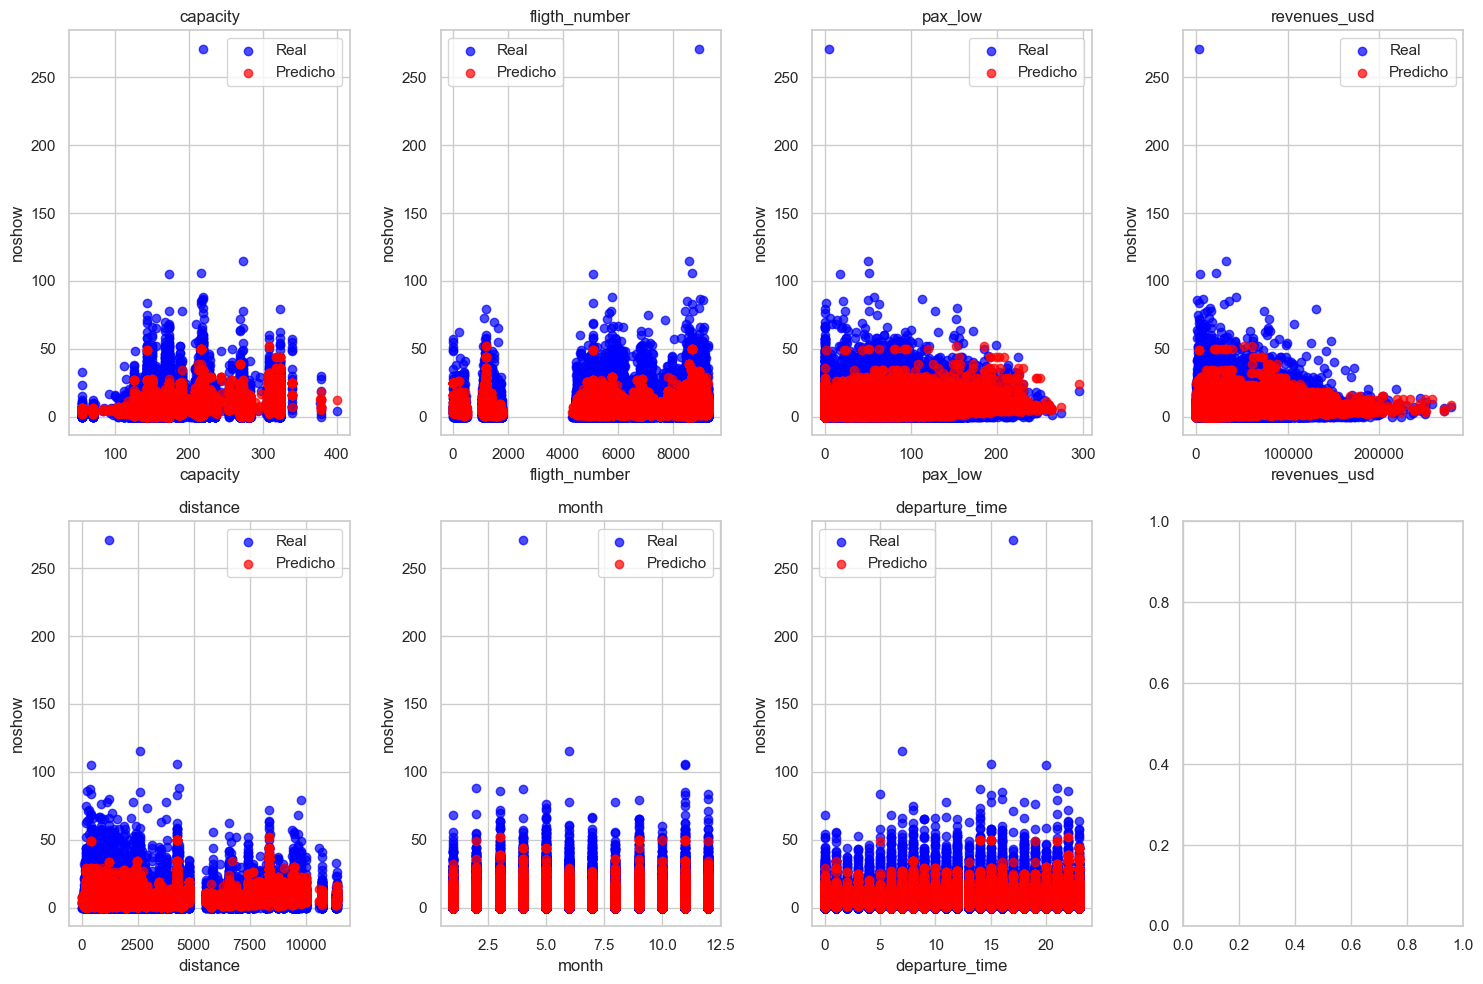

In [63]:
import matplotlib.pyplot as plt

x_variables = X.columns
graphs_per_row = 4

num_rows = len(x_variables) // graphs_per_row
if len(x_variables) % graphs_per_row > 0:
    num_rows += 1

fig, axes = plt.subplots(num_rows, graphs_per_row, figsize=(15, 5 * num_rows))

if num_rows == 1:
    axes = [axes]

for i, variable in enumerate(x_variables):
    row, col = divmod(i, graphs_per_row)
    ax = axes[row][col]

    ax.scatter(X_test[variable], y_test, color='blue', label='Real', alpha=0.7)
    ax.scatter(X_test[variable], y_pred, color='red', label='Predicho', alpha=0.7)
    ax.set_xlabel(variable)
    ax.set_ylabel("noshow")
    ax.set_title(f"{variable}")
    ax.legend()

plt.tight_layout()
plt.show()

# Comparación final entre el modelo seleccionado de kNN vs regression tree

# Competencia: predicción evalData

In [53]:
df_test = pd.read_csv('evalData.csv')
df_test.isna().sum()

Unnamed: 0           0
date                 0
fligth_number        0
origin               0
destination          0
distance             0
denied_boarding      0
pax_midlow           0
pax_high             0
pax_midhigh          0
pax_low              0
pax_freqflyer        0
group_bookings       0
out_of_stock         0
dom_cnx              0
int_cnx              0
p2p                  0
departure_time     345
capacity             0
revenues_usd         0
bookings             0
dtype: int64

Primero, limpieza de los nuevos datos (valores faltantes)

In [54]:
import pandas as pd
# Transformación para date:
df_test['date'] = pd.to_datetime(df_test['date'])
df_test['month'] = df_test['date'].dt.month
df_test = df_test.drop(columns='date')

# Transformación para departure_time:
df_test['departure_time'] = pd.to_datetime(df_test['departure_time'], errors='coerce')  # Transformación y manejo de NaT
# Extrae solo la hora de inicio (hh) y reemplaza NaT con un -1 por mientras
df_test['departure_time'] = df_test['departure_time'].apply(lambda x: x.hour if not pd.isna(x) else -1)

# Calcula la mediana de las horas de inicio (ignorando los valores -1)
median_departure_time = df_test['departure_time'][df_test['departure_time'] != -1].median()

# Imputa los valores -1 en 'departure_time' con la mediana
df_test['departure_time'].replace(-1, median_departure_time, inplace=True)

C:\Users\acata\AppData\Local\Temp\ipykernel_23904\2109112074.py:8: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.


Predecir usando kNN.

In [55]:
selected_features_knn = ['fligth_number', 'distance', 'departure_time', 'capacity']  # Variables seleccionadas
X = df_train[selected_features_knn]
y = df_train['noshow']

# Inicializar el StandardScaler y ajustarlo a los datos de entrenamiento
scaler = StandardScaler()
scaler.fit(X)

# Transforma los datos de entrenamiento
X_train_scaled = scaler.transform(X)

# Entrena el modelo KNN con los datos de entrenamiento escalados
knn_reg.fit(X_train_scaled, y)

# Selecciona las mismas características en los datos de prueba
X_test = df_test[selected_features_knn]

# Transforma los datos de prueba utilizando el mismo escalador entrenado
X_test_scaled = scaler.transform(X_test)

# Realiza predicciones en los datos de prueba
predicciones_knn = knn_reg.predict(X_test_scaled)

# Crea un DataFrame con las predicciones
predicciones_knn_df = pd.DataFrame({'Predicciones': predicciones_knn})

# Guarda las predicciones en un archivo CSV
predicciones_knn_df.to_csv('predicciones_knn.csv', index=False)

# Muestra el DataFrame con las predicciones
predicciones_knn_df

,Predicciones
0,4.187500
1,8.187500
2,8.833333
3,5.916667
4,5.104167
...,...
248875,4.416667
248876,11.458333
248877,4.812500
248878,12.187500


Predecir usando árbol

In [56]:
# Variables seleccionadas para el modelo de árbol de regresión
selected_features_arbol = ['capacity', 'fligth_number', 'pax_low', 'revenues_usd', 'distance', 'month', 'departure_time']

# Seleccionar las características del conjunto de entrenamiento
X_train_arbol = df_train[selected_features_arbol]
y_train_arbol = df_train['noshow']

# Entrenar el modelo de árbol de regresión
best_tree_reg.fit(X_train_arbol, y_train_arbol)

# Seleccionar las mismas características en los datos de prueba
X_test_arbol = df_test[selected_features_arbol]

# Realizar predicciones en los datos de prueba con el modelo de árbol de regresión
predicciones_arbol = best_tree_reg.predict(X_test_arbol)

# Crear un DataFrame con las predicciones
predicciones_arbol_df = pd.DataFrame({'Predicciones': predicciones_arbol})

# Guardar las predicciones en un archivo CSV
predicciones_arbol_df.to_csv('predicciones_arbol.csv', index=False)

# Mostrar el DataFrame con las predicciones
predicciones_arbol_df


,Predicciones
0,4.821128
1,7.309083
2,10.142857
3,4.821128
4,4.800468
...,...
248875,5.977516
248876,16.169312
248877,4.918552
248878,10.563275


In [57]:
selected_features_arbol = ['capacity', 'fligth_number', 'pax_low', 'revenues_usd', 'distance', 'month', 'departure_time'] #,'int_cnx' 

X = df_train[selected_features_arbol]
y = df_train['noshow']

best_tree_reg.fit(X, y) 
X_test = df_test[selected_features_arbol]

#from sklearn.preprocessing import StandardScaler
#scaler = StandardScaler()
#X_test_est = scaler.fit_transform(X_test) NO NECESARIO PARA ARBOL

predicciones_tree = best_tree_reg.predict(X_test)

import pandas as pd
predicciones_tree_df = pd.DataFrame({'Predicciones': predicciones_tree})
predicciones_tree_df.to_csv('predicciones_tree.csv', index=False)

predicciones_tree_df

,Predicciones
0,4.821128
1,7.309083
2,10.142857
3,4.821128
4,4.800468
...,...
248875,5.977516
248876,16.169312
248877,4.918552
248878,10.563275
